# Implementation: K-Means (Lloyd)

## Imports and Dependencies

In [1]:
"""K-Means."""
from __future__ import annotations

from functools import partial
from typing import Tuple, Union, Dict, Any
from rich.pretty import pprint
from rich import print
import numpy as np
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits, load_iris
from sklearn.model_selection import train_test_split

import random 
from matplotlib.collections import PathCollection
from typing import TypeVar
import matplotlib.pyplot as plt
import numpy as np
import torch
# from sklearn.metrics.cluster import contingency_matrix

## Utility Functions

In [2]:
def seed_all(seed: int = 1992) -> None:
    """Seed all random number generators."""
    print(f"Using Seed Number {seed}")

    # os.environ["PYTHONHASHSEED"] = str(seed)  # set PYTHONHASHSEED env var
    np.random.seed(seed)  # numpy pseudo-random generator
    random.seed(seed)  # built-in pseudo-random generator
    
def manhattan_distance(x_1: np.ndarray, x_2: np.ndarray) -> float:
    _manhattan_distance = np.sum(np.abs(x_1 - x_2))
    return _manhattan_distance

def euclidean_distance(
    x_1: np.ndarray, x_2: np.ndarray, squared: bool = False
) -> float:
    if not squared:
        _euclidean_distance = np.sum(np.square(x_1 - x_2))
    else:
        _euclidean_distance = np.sqrt(np.sum(np.square(x_1 - x_2)))
    return _euclidean_distance

## Type Hint

In [3]:
T = TypeVar("T", np.ndarray, torch.Tensor)

## Python Implementation of K-Means

We present a non-vectorized version of K-Means. I find it easier to code an algorithm
from scratch using for-loops and then vectorize it after.

In [4]:
class KMeansLloyd:
    """K-Means Lloyd's algorithm.

    Parameters
    ----------
    num_clusters : int, optional, default: 3
        The number of clusters to form as well as the number of
        centroids to generate.

    init : str, optional, default: "random"
        Method for initialization, either 'random' or 'k-means++'.

    max_iter : int, optional, default: 100
        Maximum number of iterations of the k-means algorithm for
        a single run.

    metric : str, optional, default: "euclidean"
        The distance metric used to calculate the distance between each
        sample and the centroid.

    tol : float, optional, default: 1e-8
        The tolerance with regards to the change in the within-cluster
        sum-squared-error to declare convergence.

    random_state : int, optional, default: 42
        Seed for the random number generator used during the
        initialization of the centroids.
    """

    def __init__(
        self,
        num_clusters: int = 3,
        init: str = "random",
        max_iter: int = 100,
        metric: str = "euclidean",
        tol: float = 1e-8,
        random_state: int = 42,
    ) -> None:
        self._K = num_clusters  # K
        self.init = init  # random init
        self.max_iter = max_iter

        self.metric = metric
        self.distance = self._get_distance_metric()  # get distance fn based on metric

        self.tol = tol

        self.random_state = random_state
        seed_all(self.random_state)

        self._reset_clusters()  # initializes self._C = {C_1=[], C_2=[], ..., C_k=[]}

        self._N: int
        self._D: int
        self.t: int  # iteration counter
        self._labels: T  # N labels np.zeros(shape=(self._N))
        self._centroids: T  # np.zeros(shape=(self._K, self.num_features)) KxD matrix
        self._inertia: T
        self._inertias: T  # np.zeros(shape=(self._N)) N inertias

    @property
    def num_clusters(self) -> int:
        """Property to get the number of clusters K."""
        return self._K

    @property
    def num_features(self) -> int:
        """Property to get the number of features D."""
        return self._D

    @property
    def num_samples(self) -> int:
        """Property to get the number of samples N."""
        return self._N

    @property
    def clusters(self) -> T:
        """Property to get the clusters, this is our C."""
        return self._C

    @property
    def labels(self) -> T:
        """Property to get the labels of the samples."""
        return self._labels.astype(int)

    @property
    def centroids(self) -> T:
        """Property to get the centroids."""
        return self._centroids

    @property
    def inertia(self) -> T:
        """Property to get the inertia."""
        return self._inertia

    def _reset_clusters(self) -> None:
        """Reset clusters."""
        self._C = {k: [] for k in range(self._K)}

    def _reset_inertias(self) -> None:
        """Reset inertias.

        This initializes self._inertias, and has shape N as it is the outer summation
        of our cost function J. We sum over all samples N to get self._inertia.
        """
        self._inertias = np.zeros(self._N)  # reset mechanism so don't accumulate

    def _reset_labels(self) -> None:
        """Reset labels."""
        self._labels = np.zeros(self._N)  # reset mechanism so don't accumulate

    def _init_centroids(self, X: T) -> None:
        self._centroids = np.zeros(shape=(self._K, self._D))  # KxD matrix
        if self.init == "random":
            for k in range(self._K):
                self._centroids[k] = X[np.random.choice(range(self._N))]
        else:
            raise ValueError(f"{self.init} is not supported.")

    def _get_distance_metric(self) -> Union[euclidean_distance, manhattan_distance]:
        if self.metric == "euclidean":
            return partial(euclidean_distance, squared=False)
        if self.metric == "manhattan":
            return manhattan_distance
        raise ValueError(f"{self.metric} is not supported.")

    def _compute_argmin_assignment(self, x: T, centroids: T) -> Tuple[int, float]:
        min_index = None
        min_distance = np.inf
        for k, centroid in enumerate(centroids):
            distance = self.distance(x, centroid)
            if distance < min_distance:
                # now min_distance is the best distance between x and mu_k
                min_index = k
                min_distance = distance
        return min_index, min_distance

    def _assign_samples(self, X: T, centroids: T) -> None:
        self._reset_inertias()  # reset the inertias to [0, 0, ..., 0]
        self._reset_labels()  # reset the labels to [0, 0, ..., 0]
        for sample_index, x in enumerate(X):
            min_index, min_distance = self._compute_argmin_assignment(x, centroids)
            # fmt: off
            self._C[min_index].append(x) # here means append the data point x to the cluster C_k
            self._inertias[sample_index] = min_distance  # the cost of the sample x
            self._labels[sample_index] = int(min_index)  # the label of the sample x
            # fmt: on

    def _update_centroids(self, centroids: T) -> T:
        """Update step: update the centroid with new cluster mean."""
        for k, cluster in self._C.items():  # for k and the corresponding cluster C_k
            mu_k = np.mean(cluster, axis=0)  # compute the mean of the cluster
            centroids[k] = mu_k  # update the centroid mu_k
        return centroids

    def _has_converged(self, old_centroids: T, updated_centroids: T) -> bool:
        return np.allclose(updated_centroids, old_centroids, atol=self.tol)

    def fit(self, X: T) -> None:
        """Fits K-Means to the data, after which the model will have
        centroids and labels."""
        # fmt: off
        self._N, self._D = X.shape  # N=num_samples, D=num_features

        # step 1. Initialize self._centroids of shape KxD.
        self._init_centroids(X)

        # enter iteration of step 2-3 until convergence
        for t in range(self.max_iter):
            old_centroids = self._centroids.copy()

            # step 2: assignment step
            self._assign_samples(X, old_centroids)

            # step 3: update step (careful of mutation without copy because I am doing centroids[k] = mu_k)
            self._centroids = self._update_centroids(old_centroids.copy())

            # step 4: check convergence
            if self._has_converged(old_centroids, self._centroids):
                print(f"Converged at iteration {t}")
                self.t = t  # assign iteration index, used for logging
                break

            self._reset_clusters()  # reset the clusters if not converged

        # step 5: compute the final cost on the converged centroids
        self._inertia = np.sum(self._inertias)
        # fmt: on

    def predict(self, X: T) -> T:
        """Predict cluster labels for samples in X where X can be new data or training data."""
        y_preds = np.array(
            [self._compute_argmin_assignment(x, self._centroids)[0] for x in X]
        )
        return y_preds

Let's use [scikit-learn's toy example](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans.predict) to check sanity of our implementation.

In [40]:
# sklearn example
X = np.array(
    [
        [1, 2],
        [1, 4],
        [1, 0],
        [10, 2],
        [10, 4],
        [10, 0],
    ]
)

kmeans = KMeansLloyd(num_clusters=2, init="random", max_iter=500, random_state=1992)
kmeans.fit(X)

Using Seed Number 1992

Converged at iteration 1

In [46]:
print(f"There are {kmeans.num_clusters} clusters.")
print(f"The centroids are\n{kmeans.centroids}.")
print(f"The labels predicted are {kmeans.labels}.")
print(f"The inertia is {kmeans.inertia}.")
print("The clusters are")
pprint(kmeans.clusters)

y_preds = kmeans.predict([[0, 0], [12, 3]])
print(f"The predicted labels for new data are {y_preds}.")

There are 2 clusters.

The centroids are
[[ 1.  2.]
 [10.  2.]].

The labels predicted are [0 0 0 1 1 1].

The inertia is 16.0.

The clusters are

{0: [array([1, 2]), array([1, 4]), array([1, 0])], 1: [array([10,  2]), array([10,  4]), array([10,  0])]}

The predicted labels for new data are [0 1].

Compare the results of our implementation with scikit-learn's implementation.

In [7]:
sk_kmeans = KMeans(
    n_clusters=2, random_state=1992, n_init="auto", algorithm="lloyd", max_iter=500
)
sk_kmeans.fit(X)

KMeans(max_iter=500, n_clusters=2, n_init='auto', random_state=1992)

In [8]:
print(f"The centroids are\n{sk_kmeans.cluster_centers_}.")
print(f"The labels predicted are {sk_kmeans.labels_}.")
print(f"The inertia is {sk_kmeans.inertia_}.")

y_preds = sk_kmeans.predict([[0, 0], [12, 3]])
print(f"The predicted labels for new data are {y_preds}.")

The centroids are
[[ 1.  2.]
 [10.  2.]].

The labels predicted are [0 0 0 1 1 1].

The inertia is 16.0.

The predicted labels for new data are [0 1].

## Evaluation (Performance Metrics) 

### Contigency Matrix and Purity Score

Now we code up purity score with helper functions `contingency_matrix` and `purity_score`. What are they?

Let's consider a dataset with $N$ samples and $K$ classes. The contingency matrix $C$ is an $K \times K$ matrix that represents the number of samples in the true class labels and the predicted class labels. For example, if the true class label of sample $i$ is $j$ and the predicted class label of sample $i$ is $k$, then $C_{j,k}$ is incremented by 1.

The contingency matrix $C$ can be used to calculate the Rand index, also known as the purity score, which measures the similarity between the true class labels and the predicted class labels. The Rand index is defined as the ratio of the number of pairs of samples that are either both in the same cluster or in different clusters in the predicted result and in the true class labels, to the total number of pairs of samples. Mathematically, the Rand index can be defined as:

$$R = \frac{(a + d)}{(a + b + c + d)}$$

where:

- $a$ is the number of pairs of samples that are in the same cluster in both the predicted result and the true class labels.
- $b$ is the number of pairs of samples that are in the same cluster in the predicted result and in different clusters in the true class labels.
- $c$ is the number of pairs of samples that are in different clusters in the predicted result and in the same cluster in the true class labels.
- $d$ is the number of pairs of samples that are in different clusters in both the predicted result and the true class labels.

The Rand index ranges from 0, indicating a poor match between the true class labels and the predicted class labels, to 1, indicating a perfect match. The Rand index is a widely used evaluation metric for clustering algorithms, and is often used to compare the performance of different clustering algorithms on a given dataset.

In [9]:
from typing import Union
import pandas as pd

def contingency_matrix(
    y_trues: np.ndarray, y_preds: np.ndarray, as_dataframe: bool = False
) -> Union[pd.DataFrame, np.ndarray]:
    """Contingency matrix for clustering. Similar to confusion matrix for classification.

    Note:
        One immediate problem is it does not ensure that each predicted cluster
        label is assigned only once to a true label.
    """
    # fmt: off
    classes, class_idx = np.unique(y_trues, return_inverse=True)     # get the unique classes and their indices
    clusters, cluster_idx = np.unique(y_preds, return_inverse=True)  # get the unique clusters and their indices
    num_classes, num_clusters = classes.shape[0], clusters.shape[0] # get the number of classes and clusters
    # fmt: on

    # initialize the contingency matrix with shape num_classes x num_clusters
    # exactly the same as the confusion matrix but in confusion matrix
    # the rows are the true labels and the columns are the predicted labels
    # and hence is num_classes x num_classes instead of num_classes x num_clusters
    # however in kmeans for example it is possible to have len(np.unique(y_true)) != len(np.unique(y_pred)
    # i.e. the number of clusters is not equal to the number of classes
    contingency_matrix = np.zeros((num_classes, num_clusters), dtype=np.int64)

    # note however y_true and y_pred are same sequence of samples
    for i in range(class_idx.shape[0]):
        # loop through each sample and increment the contingency matrix
        # at the row corresponding to the true label and column corresponding to the predicted label
        # so if the sample index is i = 0, and class_idx[i] = 1 and cluster_idx[i] = 2
        # this means the gt label is 1 and the predicted label is 2
        # so we increment the contingency matrix at row 1 and column 2 by 1
        # then for each row, which is the row for each gt label,
        # we see which cluster has the highest number of samples and that is the cluster
        # that the gt label is most likely to belong to.
        # in other words since kmeans permutes the labels, we can't just compare the labels
        # directly.
        contingency_matrix[class_idx[i], cluster_idx[i]] += 1

    # row is the true label and column is the predicted label
    if as_dataframe:
        return pd.DataFrame(
            contingency_matrix,
            index=[f"true={c}" for c in classes],
            columns=[f"pred={c}" for c in clusters],
        )
    return contingency_matrix


def purity_score(
    y_trues: np.ndarray, y_preds: np.ndarray, per_cluster: bool = False
) -> float:
    """Computes the purity score for clustering.

    Note:
        Potentially misleading score just like accuracy.
        Imbalanced datasets will give high scores.
    """
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix_ = contingency_matrix(y_trues, y_preds, as_dataframe=False)

    # total purity is the max value in each column divided by the sum of the matrix
    # this means for each cluster k, we find the gt label that has the most samples in that cluster
    # and then sum up all clusters and we divide by the total number of samples in all clusters

    # if per_cluster is True, we return the purity for each cluster
    # this means instead of sum up all clusters, we return the purity for each cluster.
    if per_cluster:
        return np.amax(contingency_matrix_, axis=0) / np.sum(
            contingency_matrix_, axis=0
        )
    # return purity which is the sum of the max values in each column divided by the sum of the matrix
    return np.sum(np.amax(contingency_matrix_, axis=0)) / np.sum(contingency_matrix_)


In [10]:
def display_contingency_and_purity(
    y_trues: np.ndarray,
    y_preds: np.ndarray,
    as_dataframe: bool = True,
    per_cluster: bool = False,
) -> None:
    """Display contingency matrix and purity score for clustering."""
    # compute contingency matrix
    contingency_matrix_ = contingency_matrix(
        y_trues, y_preds, as_dataframe=as_dataframe
    )
    display(contingency_matrix_)

    purity = purity_score(y_trues, y_preds, per_cluster=per_cluster)
    print(f"Purity score: {purity:.4f}")

## K-Means Algorithm on IRIS

We use first two features of IRIS dataset to visualize the clusters.

In [11]:
X, y = load_iris(return_X_y=True)
X = X[:, :2] # only use the first two features

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [12]:
kmeans = KMeansLloyd(num_clusters=3, init="random", max_iter=500, random_state=2023)
kmeans.fit(X_train)

Using Seed Number 2023

Converged at iteration 8

In [13]:
print(f"There are {kmeans.num_clusters} clusters.")
print(f"The centroids are\n{kmeans.centroids}.")
print(f"The labels predicted are {kmeans.labels}.")
print(f"The inertia is {kmeans.inertia}.")

There are 3 clusters.

The centroids are
[[7.06153846 3.08461538]
 [4.99423077 3.31346154]
 [6.01428571 2.88095238]].

The labels predicted are [2 1 0 1 2 2 2 2 1 0 1 1 1 1 0 1 0 1 1 1 0 2 1 2 0 2 1 1 1 2 1 1 2 1 1 2 0
 0 2 2 2 0 0 2 0 2 1 2 0 0 1 1 2 1 2 2 2 1 1 2 1 2 0 1 1 1 1 1 2 1 0 2 1 1
 0 1 0 2 2 2 0 2 1 1 2 1 0 0 1 2 0 2 1 2 1 0 2 2 2 1 1 0 1 1 2 1 2 2 2 0 1
 1 2 1 0 2 1 0 1 1].

The inertia is 29.54042124542125.

In [14]:
y_preds = kmeans.predict(X_test)
display_contingency_and_purity(y_test, y_preds, per_cluster=False)

,pred=0,pred=1,pred=2
true=0,0,4,0
true=1,1,0,12
true=2,4,1,8


Purity score: 0.6667

Let's visualize where the centroids are.

In [15]:
def plot_scatter(
    ax: plt.Axes, x: np.ndarray, y: np.ndarray, **kwargs: Dict[str, Any]
) -> PathCollection:
    """Plot scatter plot."""
    return ax.scatter(x, y, **kwargs)

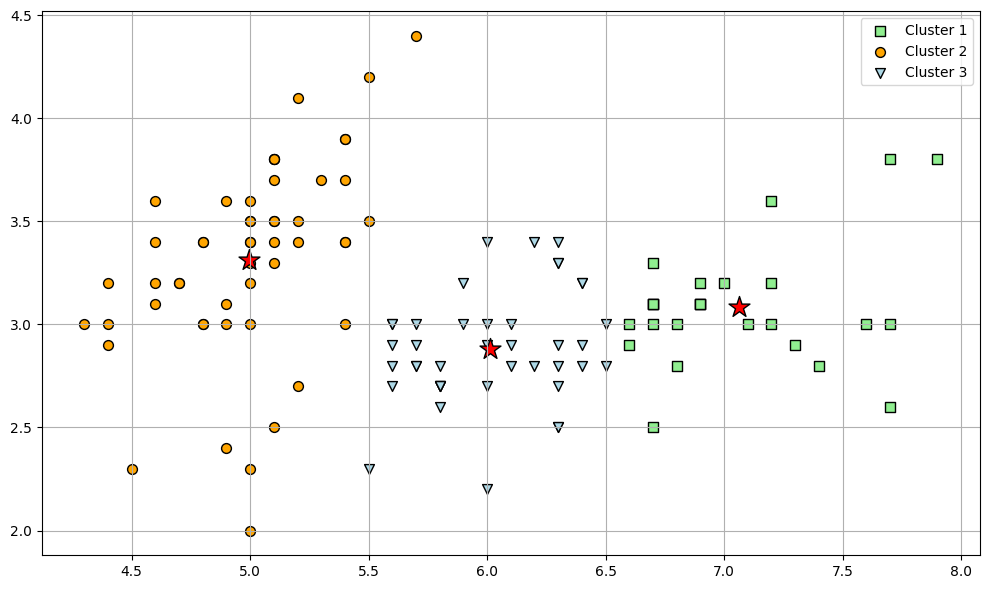

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))

labels = kmeans.labels

# Note: X_train[y_train == 0] is NOT the same as X_train[labels == 0]
cluster_1 = X_train[labels == 0]  # cluster 1
cluster_2 = X_train[labels == 1]  # cluster 2
cluster_3 = X_train[labels == 2]  # cluster 3

scatter_1 = plot_scatter(
    ax,
    cluster_1[:, 0],
    cluster_1[:, 1],
    s=50,
    c="lightgreen",
    marker="s",
    edgecolor="black",
    label="Cluster 1",
)
scatter_2 = plot_scatter(
    ax,
    cluster_2[:, 0],
    cluster_2[:, 1],
    s=50,
    c="orange",
    marker="o",
    edgecolor="black",
    label="Cluster 2",
)
scatter_3 = plot_scatter(
    ax,
    cluster_3[:, 0],
    cluster_3[:, 1],
    s=50,
    c="lightblue",
    marker="v",
    edgecolor="black",
    label="Cluster 3",
)

centroids = kmeans.centroids

plot_scatter(
    ax,
    centroids[:, 0],
    centroids[:, 1],
    s=250,
    marker="*",
    c="red",
    edgecolor="black",
    label="Centroids",
)

plt.legend(handles=[scatter_1, scatter_2, scatter_3])
plt.grid()
plt.tight_layout()
plt.show()

In [17]:
sk_kmeans = KMeans(
    n_clusters=3,
    random_state=2023,
    n_init=1,
    algorithm="lloyd",
    max_iter=1000,
    init="random",
)
sk_kmeans.fit(X_train)

KMeans(init='random', max_iter=1000, n_clusters=3, n_init=1, random_state=2023)

In [18]:
print(f"The labels predicted are {sk_kmeans.labels_}.")
print(f"The inertia is {sk_kmeans.inertia_}.")

The labels predicted are [1 0 2 0 1 2 2 1 0 2 0 0 0 1 2 0 2 0 0 1 2 1 0 1 2 1 1 0 0 2 0 0 2 0 0 1 2
 2 1 1 1 2 2 1 2 1 0 1 2 2 0 0 1 0 1 1 1 0 0 1 1 1 2 0 0 0 0 0 1 0 2 1 0 0
 2 1 2 1 2 2 2 1 0 0 1 0 2 2 0 2 2 1 0 2 1 2 1 1 1 0 0 2 0 0 1 0 1 1 1 2 0
 0 2 0 2 2 0 2 0 0].

The inertia is 29.560184337655734.

In [19]:
y_preds = sk_kmeans.predict(X_test)
display_contingency_and_purity(y_test, y_preds, per_cluster=False)

,pred=0,pred=1,pred=2
true=0,4,0,0
true=1,0,12,1
true=2,0,4,9


Purity score: 0.8333

Let's try use elbow method. We fix the same seed but change the number of clusters in
each run. For example, if I want to test 2, 3, 4, 5, 6, 7, 8, 9, 10 clusters, I will
define `max_clusters = 10` and the code will loop through 2 to 10 clusters.

Note that the code will auto start from 2 clusters and end at `max_clusters` clusters
as it does not make sense to have 1 cluster.

In [20]:
def elbow_method(X: T, min_clusters: int = 1, max_clusters: int = 10) -> None:
    """Elbow method to find the optimal number of clusters.
    The optimal number of clusters is where the elbow occurs.
    The elbow is where the SSE starts to decrease in a linear fashion."""
    inertias = []
    for k in range(min_clusters, max_clusters + 1):
        print(f"Running K-Means with {k} clusters")
        kmeans = KMeansLloyd(
            num_clusters=k, init="random", max_iter=500, random_state=1992
        )
        kmeans.fit(X)
        inertias.append(kmeans.inertia)
    plt.plot(range(min_clusters, max_clusters + 1), inertias, marker="o")
    plt.title("Elbow Method")
    plt.xlabel("Number of clusters")
    plt.ylabel("Intertia/Distortion/SSE")
    plt.tight_layout()
    plt.show()

Running K-Means with 1 clusters

Using Seed Number 1992

Converged at iteration 1

Running K-Means with 2 clusters

Using Seed Number 1992

Converged at iteration 6

Running K-Means with 3 clusters

Using Seed Number 1992

Converged at iteration 4

Running K-Means with 4 clusters

Using Seed Number 1992

Converged at iteration 7

Running K-Means with 5 clusters

Using Seed Number 1992

Converged at iteration 9

Running K-Means with 6 clusters

Using Seed Number 1992

Converged at iteration 4

Running K-Means with 7 clusters

Using Seed Number 1992

Converged at iteration 3

Running K-Means with 8 clusters

Using Seed Number 1992

Converged at iteration 3

Running K-Means with 9 clusters

Using Seed Number 1992

Converged at iteration 4

Running K-Means with 10 clusters

Using Seed Number 1992

/usr/local/Caskroom/miniforge/base/envs/gaohn-galaxy/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/Caskroom/miniforge/base/envs/gaohn-galaxy/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


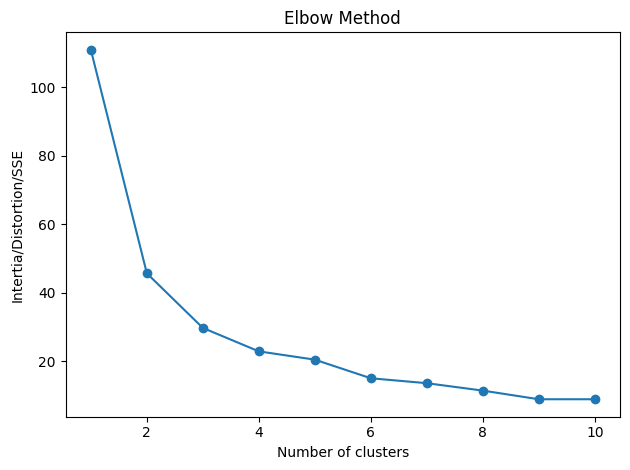

In [21]:
_ = elbow_method(X_train, min_clusters=1, max_clusters=10)

What happened here?

```bash
/usr/local/Caskroom/miniforge/base/envs/gaohn/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/Caskroom/miniforge/base/envs/gaohn/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
```

This means 

```python
mu_k = np.mean(cluster, axis=0)  # compute the mean of the cluster
```

is returning `nan` because the cluster is empty. This is because for that cluster in
the previous iteration, there is no data point assigned to it. This can happen because
no data points are close enough to the centroid of that cluster. In this case, this
is likely a case of [bad initialization](https://datascience.stackexchange.com/questions/44897/k-means-clustering-what-to-do-if-a-cluster-has-0-elements), and to solve this, either you
reduce the number of clusters or you re-run the algorithm with different seed. Of course,
if you initialize data points to be far apart (e.g. K-Means++), this will be less likely
to happen.

Sometimes people also just decrement the number of clusters by 1 and continue the
program but it really must depend on the use case.

We decrease the `max_clusters` to 6 and re-run the code. 

Running K-Means with 1 clusters

Using Seed Number 1992

Converged at iteration 1

Running K-Means with 2 clusters

Using Seed Number 1992

Converged at iteration 6

Running K-Means with 3 clusters

Using Seed Number 1992

Converged at iteration 4

Running K-Means with 4 clusters

Using Seed Number 1992

Converged at iteration 7

Running K-Means with 5 clusters

Using Seed Number 1992

Converged at iteration 9

Running K-Means with 6 clusters

Using Seed Number 1992

Converged at iteration 4

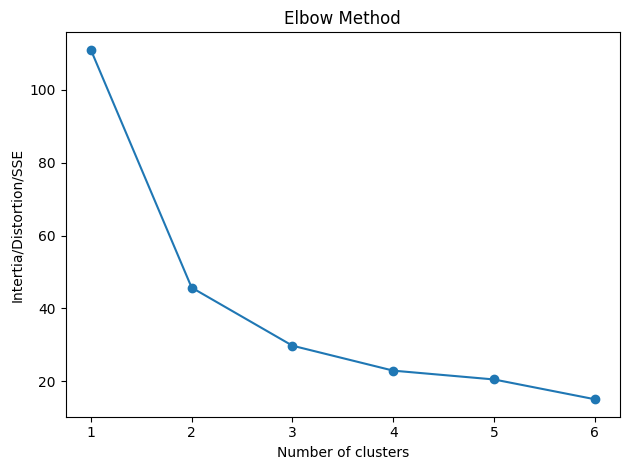

In [22]:
_ = elbow_method(X_train, min_clusters=1, max_clusters=6)

## K-Means Algorithm on MNIST

In [23]:
# X, y = load_digits(return_X_y=True)
# (num_samples, num_features), num_classes = X.shape, np.unique(y).size
# print(f"There are {num_samples} samples and {num_features} features.")
# print(f"Shape of X is {X.shape} and shape of y is {y.shape}.")

In [24]:
import tensorflow as tf

2023-03-07 21:11:53.451959: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [25]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
assert X_train.shape == (60000, 28, 28)
assert X_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

In [26]:
num_classes = np.unique(y_train).size

X_train = X_train.reshape(-1, 28 * 28)
X_test = X_test.reshape(-1, 28 * 28)

# Do not run this multiple times in jupyter notebook
X_train = X_train / 255.0
X_test = X_test / 255.0

print(f"Shape of X_train is {X_train.shape} and shape of X_test is {X_test.shape}.")

Shape of X_train is (60000, 784) and shape of X_test is (10000, 784).

ATTENTION: due to the implementation, vectorization is not fully
optimized and hence we train on `X_test` instead of `X_train` to
quickly get some results.

In [27]:
kmeans = KMeansLloyd(
    num_clusters=num_classes, init="random", max_iter=20, random_state=42
)

kmeans.fit(X_test)

Using Seed Number 42

In [28]:
print(f"The inertia is {kmeans.inertia}.")

The inertia is 391367.5505466436.

In [29]:
sk_kmeans = KMeans(
    n_clusters=num_classes,
    random_state=42,
    n_init=1,
    init="random",
    max_iter=500,
    algorithm="lloyd",
)

sk_kmeans.fit(X_test)

KMeans(init='random', max_iter=500, n_clusters=10, n_init=1, random_state=42)

The inertia looks frighteningly high because of the large number of samples.
Since our cost function is SSE, it sums all errors over all samples. Average SSE
will tells us roughly the loss per sample.

In [30]:
print(f"The inertia is {sk_kmeans.inertia_}.")

The inertia is 390846.1005761042.

In [31]:
y_preds = kmeans.labels
contingency_matrix_ = contingency_matrix(y_test, y_preds, as_dataframe=True)
contingency_matrix_ 

,pred=0,pred=1,pred=2,pred=3,pred=4,pred=5,pred=6,pred=7,pred=8,pred=9
true=0,3,23,2,321,2,12,31,2,42,542
true=1,1102,2,23,0,0,1,4,0,3,0
true=2,142,16,716,3,17,16,23,8,70,21
true=3,62,4,46,1,12,9,143,11,718,4
true=4,28,20,3,8,414,278,1,229,0,1
true=5,94,10,6,12,41,106,315,23,267,18
true=6,67,697,7,120,12,0,36,2,1,16
true=7,68,0,14,5,118,361,1,461,0,0
true=8,81,8,13,8,19,54,572,23,188,8
true=9,23,2,2,11,336,196,11,411,7,10


In [32]:
purity = purity_score(y_test, y_preds)
print(purity)
purity_per_cluster = purity_score(y_test, y_preds, per_cluster=True)
print(purity_per_cluster)

0.5904

[0.65988024 0.89130435 0.86057692 0.65644172 0.42636457 0.34946757
 0.50307828 0.39401709 0.55401235 0.87419355]

In [33]:
sk_y_preds = sk_kmeans.labels_
sk_contingency_matrix_ = contingency_matrix(y_test, sk_y_preds, as_dataframe=True)
sk_contingency_matrix_

,pred=0,pred=1,pred=2,pred=3,pred=4,pred=5,pred=6,pred=7,pred=8,pred=9
true=0,16,1,435,1,15,1,43,3,1,464
true=1,2,491,0,638,0,0,4,0,0,0
true=2,20,109,4,58,21,704,55,24,11,26
true=3,5,3,1,72,37,51,791,11,11,28
true=4,21,10,4,32,313,1,0,574,26,1
true=5,10,18,18,51,273,3,382,53,12,72
true=6,753,8,29,57,24,8,13,9,0,57
true=7,0,50,2,37,137,9,0,156,636,1
true=8,10,29,8,28,365,14,449,28,18,25
true=9,4,4,7,24,199,2,13,485,259,12


In [34]:
purity = purity_score(y_test, sk_y_preds)
print(purity)
purity_per_cluster = purity_score(y_test, sk_y_preds, per_cluster=True)
print(purity_per_cluster)

0.5851

[0.89536266 0.6791148  0.85629921 0.63927856 0.26372832 0.88776797
 0.452      0.42740134 0.65297741 0.67638484]

Use distance metric `manhattan` instead of `euclidean` to see if we can get better results.

In [35]:
kmeans = KMeansLloyd(
    num_clusters=num_classes, init="random", max_iter=150, random_state=2023, metric="manhattan"
)

kmeans.fit(X_test)

Using Seed Number 2023

Converged at iteration 46

In [36]:
print(f"The inertia is {kmeans.inertia}.")

The inertia is 917674.1205970906.

In [37]:
y_preds = kmeans.labels
contingency_matrix_ = contingency_matrix(y_test, y_preds, as_dataframe=True)
contingency_matrix_ 

,pred=0,pred=1,pred=2,pred=3,pred=4,pred=5,pred=6,pred=7,pred=8,pred=9
true=0,2,5,14,39,44,476,21,2,30,347
true=1,0,0,0,0,1,0,1,0,1133,0
true=2,474,8,23,2,32,18,11,52,411,1
true=3,6,11,24,204,507,2,2,35,219,0
true=4,0,463,386,0,0,1,16,0,115,1
true=5,1,38,115,183,200,7,8,50,286,4
true=6,0,12,1,2,7,16,682,0,223,15
true=7,5,189,704,0,0,0,0,1,129,0
true=8,0,14,88,83,34,6,3,424,317,5
true=9,1,428,498,5,4,8,3,6,55,1


In [38]:
purity = purity_score(y_test, y_preds)
print(purity)
purity_per_cluster = purity_score(y_test, y_preds, per_cluster=True)
print(purity_per_cluster)

0.5414

[0.96932515 0.39640411 0.37992445 0.39382239 0.61158022 0.89138577
 0.91298527 0.74385965 0.38827964 0.92780749]

Try cosine distance since vectors lie in a unit sphere?